<a href="https://colab.research.google.com/github/AaryaDesai1/PDP_ICE_ALE/blob/main/PDP_ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590- XAI | Assignment #06

## Aarya Desai

# Table of Contents


>[Table of Contents](#scrollTo=_Nl9xAx-Off1)

>[Setting up the Notebook](#scrollTo=sFqTBNnTPfD2)

>>[Installing necessary libraries](#scrollTo=XqaDkpBvNs5S)

>>[Importing the Libraries](#scrollTo=0DU9WRYAPSLB)

>>[Loading the data](#scrollTo=JxWHwvr2TmJK)

>>[Training the Model](#scrollTo=WPMkVvdhV_gy)

>[Explainable ML](#scrollTo=OPcCHp6IXpsE)

>>[Partial Dependence Plots (PDP):](#scrollTo=4Sr_dhRyXrLK)

>>>[What is a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[How to use a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[How to interpret a PDP?](#scrollTo=4Sr_dhRyXrLK)

>>>[Interpreting the PDP for Median Income](#scrollTo=3TFMaH4rlsL0)

>>>[Strengths and Weaknesses of PDPs](#scrollTo=CORU6QdilsL0)

>>[Individual Conditional Expectation (ICE) Plots](#scrollTo=c5o6Ar2XlsL0)

>>>[What is an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[How to use an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[How to interpret an ICE Plot?](#scrollTo=c5o6Ar2XlsL0)

>>>[Interpreting the ICE Plot for Median Income](#scrollTo=tpk-pQ6FlsL1)

>>>[Strengths and Weaknesses of ICE Plots](#scrollTo=ImBNBZkBlsL1)

>>[Accumulated Local Effects (ALE) Plots](#scrollTo=Z4fyfZiAlsL2)

>>>[What is an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[How to use an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[How to interpret an ALE Plot?](#scrollTo=Z4fyfZiAlsL2)

>>>[Interpreting the ALE Plot for Median Income](#scrollTo=sdpLuyfOlsL2)

>>>[Strengths and Weaknesses of ALE Plots](#scrollTo=na9_5PXQlsL2)



# Setting up the Notebook

## Installing necessary libraries
This was taken from Dr. Bent's `Global Explanations` demo notebook. Here, we are installing the following libraries:
- `numpy==1.25.2`: for numerical computations, specifically for large multi-dimensional arrays and matrices.
- `pandas==2.0.3`: for data manipulation and analyses.
- `scikit-learn==1.2.2`: a library for machine learning, data mining, analysis, and modeling. Here, it's also used to import the dataset we will be using.
- `shap==0.45.1`: A library for explaining machine learning models using SHAP values, which provide insights into feature importance.
- `alepython`: A library for calculating Accumulated Local Effects (ALE), a method used to understand the behavior of machine learning models by analyzing feature interactions.


In [ ]:
!pip install numpy == 1.25.2 pandas == 2.0.3 scikit-learn == 1.2.2 shap == 0.45.1
!pip install git+https: // github.com/MaximeJumelle/ALEPython.git@dev  # egg=alepython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 37.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 40.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.0 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Success

## Importing the Libraries

The next step is to import all the libraries that were installed in the previous block (and a few more). The in-code comments give some extra information about what the libraries are for.

In [ ]:
# For the model
from sklearn.ensemble import RandomForestRegressor

# For the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For explainability
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance


## Loading the data  

**Dataset**: This dataset contains information about house prices in California based on various features like median income, house age, and location. It's relatively simple but has enough complexity for feature interaction analysis, which is why it was chosen for this demo. Here, the `y` or the outcome variable is the median house price, and the `X` or the feature variables are the other columns in the dataset (including, `median income`, `house age`, `average rooms`, `average bedrooms`, `population`, `average occupation`, `latitude` and `longitude`).

**Train-Test Split**: The data is then split into a train and test set to train the model on and test it respectively. A standard 80-20 split is used. I also set a random seed to make sure the same datapoints are in the train and test sets any time the cell is run to ensure consistency.

In [ ]:
# Loading the data
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data  # Features
y = california_housing.target  # Target variable (housing prices)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


## Training the Model

The model I chose to use for this demo is a `Random Forest` as it works extremely well for structured and tabular data, which is the case for this demo.

It’s an ensemble of decision trees, where the output is averaged, making it harder to understand the contribution of individual features. So, having explainable plots for the results of this model should be a good way to demonstrate how PDP, ICE and ALE plots work.

In [ ]:
# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

# Explainable ML

## Partial Dependence Plots (PDP):

### What is a PDP?
A PDP shows the marginal effect of a feature on the predicted outcome of a machine learning model. It shows how the model's predictions change as a feature changes while keeping all other features constant.

### How to use a PDP?
- Select a feature you want to analyze. Here, I chose the `median income` feature as an example because I think that it may have a significant effect on the median house price.
- Calculate the average prediction of the model for different values of the feature.
- Plot the feature values on the x-axis and the average predictions on the y-axis.

### How to interpret a PDP?
- If the PDP is flat, it means that the feature has no effect on the prediction.
- If the PDP is increasing, it means that the feature has a positive effect on the prediction.
- If the PDP is decreasing, it means that the feature has a negative effect on the prediction.

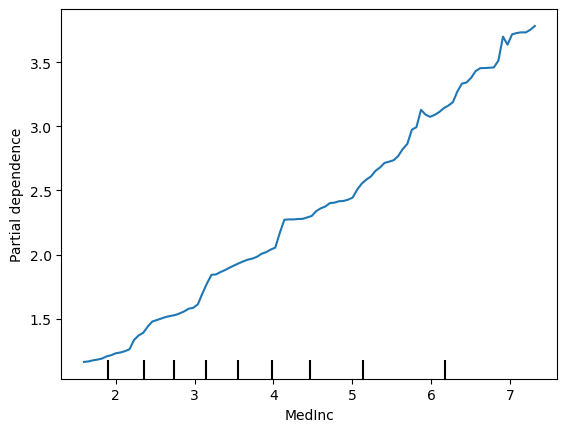

In [ ]:
# Feature of interest
median_income = X_train['MedInc']

# Plotting the PDP plot
pdp = PartialDependenceDisplay.from_estimator(
    model, X_train, features=['MedInc'])


In [ ]:
# Finding ranging of the median income
min_median_income = median_income.min()
max_median_income = median_income.max()
print(f"Min median income: {min_median_income}")
print(f"Max median income: {max_median_income}")


Min median income: 0.4999
Max median income: 15.0001


### Interpreting the PDP for Median Income

First, it is important to note the scale of the median income variable. The values range from 0.5 to 15, which seems like extremely small numbers for income. However, it seems that this is a scaled version of median income, likely noted in tens of thousands of dollars. So, a value of 3 would mean a median income of $30,000.

The PDP for median income shows that `as the median income increases, the median house price also increases`. This is expected as higher income areas tend to have more expensive houses. The PDP is increasing, which means that the median income has a positive effect on the median house price. This is a very clear and intuitive result.

### Strengths and Weaknesses of PDPs

**Strengths**:
1. PDPs are easy to understand and interpret.
2. They show the marginal effect of a feature on the prediction.

**Weaknesses**:
1. PDPs assume that the features are independent of each other, which is not always the case.
2. They do not show the interaction between features.

## Individual Conditional Expectation (ICE) Plots  

### What is an ICE Plot?
ICE plots are similar to PDPs, but instead of showing the average effect of a feature, they show the effect of a feature on the prediction for each individual data point. This allows us to see how the feature affects the prediction for different data points.

### How to use an ICE Plot?
- Select a feature you want to analyze. Here, I chose the `median income` feature as an example again.
- Calculate the prediction of the model for different values of the feature for each data point.
- Plot the feature values on the x-axis and the predictions on the y-axis.

### How to interpret an ICE Plot?
The individual lines on an ICE plot show the effect of the feature on the prediction for each data point. The average effect of the feature is shown by the PDP (i.e., the plot above).

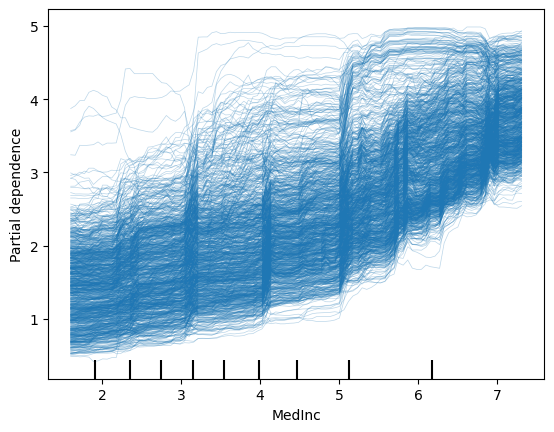

In [ ]:
# Plotting the ICE plot
ice = PartialDependenceDisplay.from_estimator(
    model, X_train, features=['MedInc'], kind='individual')


### Interpreting the ICE Plot for Median Income
As we can see from the plot above the individual lines show the effect of median income on the median house price for each data point. The lines are not smooth because they represent the effect of median income on the prediction for each individual data point. However, intuitively, we can tell that the average of these lines would be the same as the PDP plot from before.

### Strengths and Weaknesses of ICE Plots

**Strengths**:
1. Provides a more detailed view of the effect of a feature on the prediction.
2. Shows the effect of a feature on the prediction for each data point.

**Weaknesses**:
1. Could be a bit difficult to interpret if there are many data points.
2. Does not show the interaction between features.

## Accumulated Local Effects (ALE) Plots

### What is an ALE Plot?
ALE plots show the accumulated effect of a feature on the prediction. They are similar to PDPs but are more robust to feature interactions. ALE plots show the effect of a feature on the prediction while accounting for the effect of other features.

### How to use an ALE Plot?
- Select a feature you want to analyze. Here, I chose the `median income` feature as an example again.
- Calculate the prediction of the model for different values of the feature.
- Calculate the difference between the predictions for each value of the feature and the predictions for the previous value of the feature.
- Plot the feature values on the x-axis and the accumulated effects on the y-axis.

### How to interpret an ALE Plot?
- If the ALE plot is flat, it means that the feature has no effect on the prediction.
- If the ALE plot is increasing, it means that the feature has a positive effect on the prediction.
- If the ALE plot is decreasing, it means that the feature has a negative effect on the prediction.


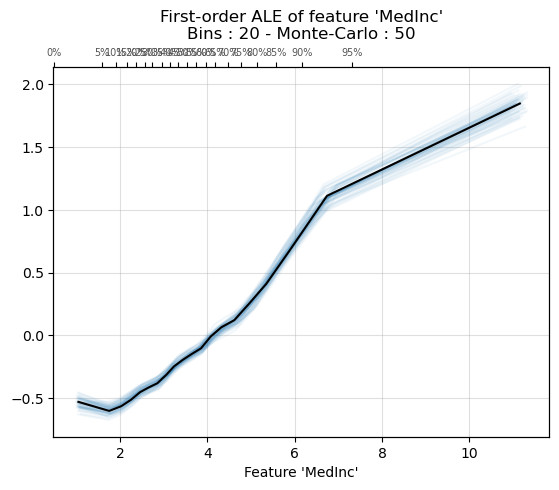

<Axes: title={'center': "First-order ALE of feature 'MedInc'\nBins : 20 - Monte-Carlo : 50"}, xlabel="Feature 'MedInc'">

In [ ]:
# plottin the ALE plot
ale_plot(model, X_train, features=['MedInc'], bins=20, monte_carlo=True)


### Interpreting the ALE Plot for Median Income
The ALE plot for median income shows that `as the median income increases, the median house price also increases`. This is the same result as the PDP plot from before. However, the ALE plot is more robust to feature interactions, which makes it a better choice when analyzing the effect of a feature on the prediction.

Here, I also used a monte carlo method to calculate the ALE plot, which is a more accurate way to calculate the ALE plot. The monte carlo method calculates the ALE plot by randomly sampling the data points and calculating the effect of the feature on the prediction for each sample. This is a more accurate way to calculate the ALE plot because it accounts for the effect of other features on the prediction.

### Strengths and Weaknesses of ALE Plots

**Strengths**:
1. More robust to feature interactions.
2. Provides a more accurate view of the effect of a feature on the prediction.

**Weaknesses**:
1. Can be difficult to interpret if there are many data points.
2. There is a dependence on intervals. Therefore, depending on the intervals chosen, the ALE plot may look different.